In [2]:
from pymoo.algorithms.nsga3_uip import NSGA3
from joblib import Parallel,delayed
from pymoo.factory import get_problem, get_crossover, get_mutation, get_performance_indicator, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.model.problem import Problem
import autograd.numpy as anp
import math
import time
import numpy as np
from pymoo.model.callback import Callback
from pymoo.util.normalization import normalize
from copy import deepcopy
        
class MyCallback(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.data["f-values"] = []
        self.data["x-values"] = []
        self.data["c-values"] = []
        self.data["archive"] = []

    def notify(self, algorithm):
        self.data["f-values"] = algorithm.pop.get("F")
        self.data["x-values"] = algorithm.pop.get("X")
        self.data["c-values"] = algorithm.pop.get("CV")
        self.data["archive"].append(algorithm.pop)

In [3]:
# Set the problem to run
name = 'dascmop9'
problem = get_problem(name, 5)

# Set the seed; n_gen is an arbitrarily high number of generations, algorithm will terminate before that on its own
seed = 1
n_gen=15000

# Set the SBX crossover and polynomial mutation parameters
crossover = get_crossover("real_sbx", prob=0.9, eta=20)
mutation = get_mutation("real_pm", prob=1/problem.n_var, eta=20)

# Set the reference-vectors using the Das & Dennis method
if problem.n_obj==2:
    ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=99)
elif problem.n_obj==3:
    ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=13)

# Instantiate the algorithm object
algorithm = NSGA3(
    pop_size=len(ref_dirs), # population size same as the number of reference-vectors
    ref_dirs=ref_dirs, 
    crossover=crossover, 
    mutation=mutation, 
    eliminate_duplicates=True
)

# Execute the optimization
res = minimize(
    problem, 
    algorithm, 
    ('n_gen', n_gen), 
    seed=seed, 
    callback=MyCallback(), 
    verbose=False
)

# Save the data
for key in ["f-values", "c-values", "x-values"]:
    df = np.array(res.algorithm.callback.data[key])
    np.save("data/"+name+'-'+key+'-'+str(seed)+'.npy', df)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False

Generation: 100
Generation: 200
mild stabilization has reached at gen: 202
Generation: 300
Generation: 400
Generation: 500
Generation: 600
Generation: 700
intermediate stabilization has reached at gen: 703
Generation: 800
Generation: 900
Generation: 1000
Generation: 1100
Generation: 1200
Generation: 1300
Generation: 1400
strict stabilization has reached at gen: 1467


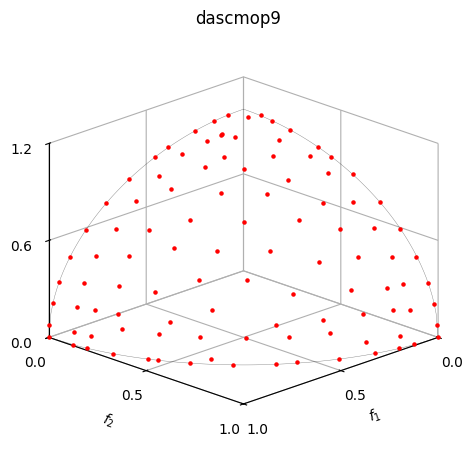

In [11]:
from pymoo.visualization.scatter import Scatter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

df = np.load("data/"+name+'-f-values-'+str(seed)+'.npy')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
x = np.linspace(0, 1, 100)
y = [(1 - row**2)**.5 for row in x]
z = [0 for row in x]

w = 0.3

ax.plot(x, y, z, '-k', linewidth = w, alpha = 0.5)
ax.plot(x, z, y, '-k', linewidth = w, alpha = 0.5)
ax.plot(z, x, y, '-k', linewidth = w, alpha = 0.5)

ax.scatter(df[:, 0], df[:, 1], df[:, 2], color='red', marker='.', depthshade=False)
ax.set_xlabel('$f_1$', labelpad=7)
ax.set_ylabel('$f_2$', labelpad=10)
ax.set_zlabel('$f_3$')

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

ax.set_xlim(0, 1)
ax.set_xticks([0, 0.5, 1])
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.5, 1])
ax.set_zlim(0, 1.2)
ax.set_zticks([0, 0.6, 1.2])
plt.title(name)
ax.view_init(20, 45)
plt.tight_layout()